# ERKEN FÜZYON

In [ ]:
#metin ve ses özellik pencereleri birleştiriliyor
train_combined = np.concatenate((text_train_windows, audio_train_windows), axis=-1)
val_combined = np.concatenate((text_val_windows, audio_val_windows), axis=-1)
test_combined = np.concatenate((text_test_windows, audio_test_windows), axis=-1)

print(f"train_combined shape: {train_combined.shape}")
print(f"val_combined shape: {val_combined.shape}")
print(f"test_combined shape: {test_combined.shape}")

train_combined shape: (9985, 5, 1911)
val_combined shape: (1105, 5, 1911)
test_combined shape: (2606, 5, 1911)


In [ ]:
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, concatenate
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score

input_shape = train_combined.shape[1:]
input_layer = Input(shape=input_shape)

conv_layer = Conv1D(filters=512, kernel_size=3, activation='relu')(input_layer)
conv_layer = BatchNormalization()(conv_layer)
conv_layer = Dropout(0.5)(conv_layer)
conv_layer = Conv1D(filters=256, kernel_size=3, activation='relu')(conv_layer)
conv_layer = GlobalAveragePooling1D()(conv_layer)

lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
lstm_layer = BatchNormalization()(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)
lstm_layer = Bidirectional(LSTM(64))(lstm_layer)
lstm_layer = BatchNormalization()(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

combined = concatenate([conv_layer, lstm_layer])

output_layer = Dense(len(label_mapping), activation='softmax')(combined)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_combined, y_train_categorical, epochs=100, batch_size=64, validation_data=(val_combined, y_val_categorical), callbacks=[early_stopping])

val_predictions = model.predict(val_combined)
test_predictions = model.predict(test_combined)

val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

val_f1 = f1_score(y_val_windows, val_pred_labels, average='weighted')
test_f1 = f1_score(y_test_windows, test_pred_labels, average='weighted')

print(f"Validation F1 Score: {val_f1}")
print(f"Test F1 Score: {test_f1}")

print("Validation Classification Report:")
print(classification_report(y_val_windows, val_pred_labels, target_names=le.classes_))
print("Test Classification Report:")
print(classification_report(y_test_windows, test_pred_labels, target_names=le.classes_))

Epoch 1/100
157/157 [==============================] - 22s 90ms/step - loss: 1.4451 - accuracy: 0.5365 - val_loss: 5.3129 - val_accuracy: 0.4244
Epoch 2/100
157/157 [==============================] - 13s 80ms/step - loss: 0.7365 - accuracy: 0.7498 - val_loss: 2.4387 - val_accuracy: 0.5176
Epoch 3/100
157/157 [==============================] - 13s 80ms/step - loss: 0.4404 - accuracy: 0.8436 - val_loss: 4.0737 - val_accuracy: 0.3312
Epoch 4/100
157/157 [==============================] - 12s 80ms/step - loss: 0.2877 - accuracy: 0.8950 - val_loss: 2.7198 - val_accuracy: 0.5231
Epoch 5/100
157/157 [==============================] - 12s 79ms/step - loss: 0.2342 - accuracy: 0.9155 - val_loss: 6.3329 - val_accuracy: 0.4679
Epoch 6/100
157/157 [==============================] - 13s 84ms/step - loss: 0.1919 - accuracy: 0.9332 - val_loss: 7.6385 - val_accuracy: 0.1548
Epoch 7/100
157/157 [==============================] - 12s 79ms/step - loss: 0.1876 - accuracy: 0.9355 - val_loss: 2.6109 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


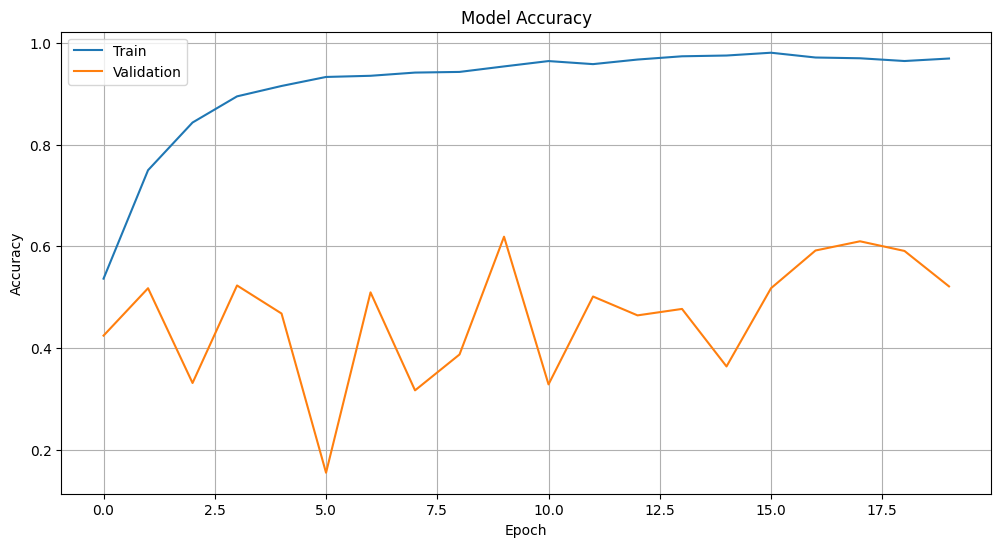

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


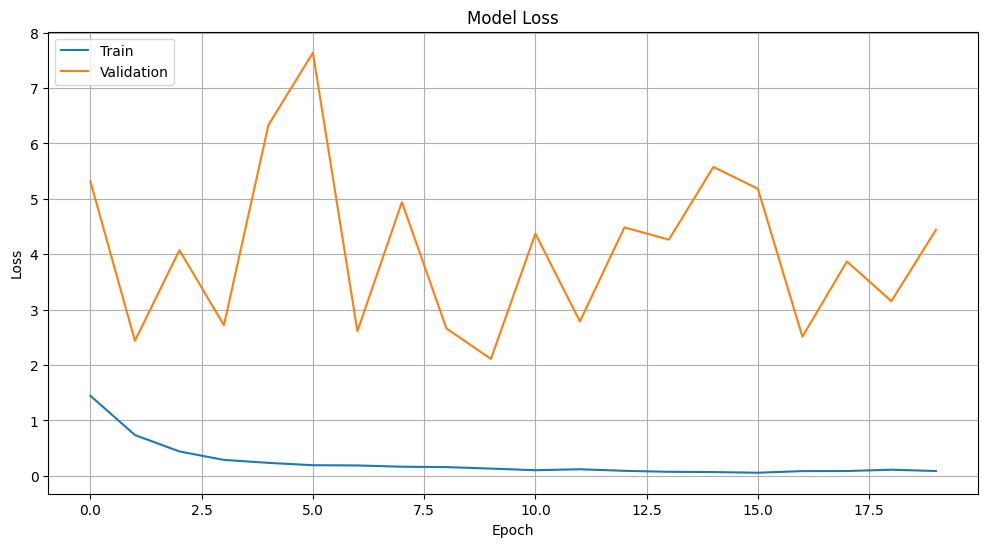

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


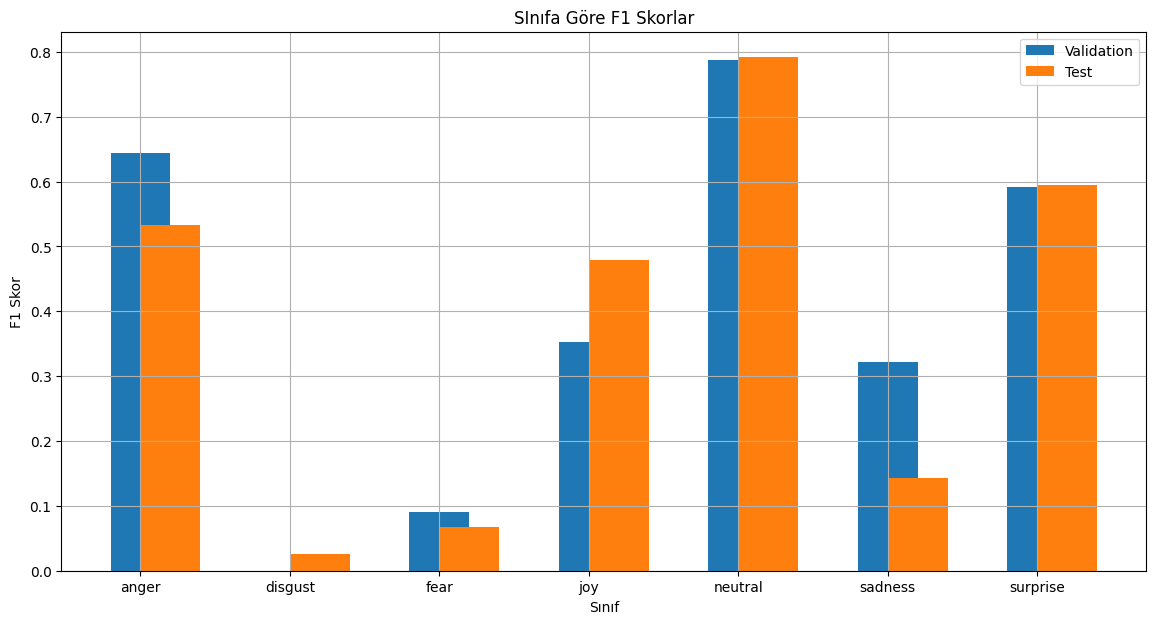

In [ ]:
from sklearn.metrics import f1_score

val_f1_scores = f1_score(y_val_windows, val_pred_labels, average=None)
test_f1_scores = f1_score(y_test_windows, test_pred_labels, average=None)

labels = le.classes_

x = range(len(labels))
plt.figure(figsize=(14, 7))
plt.bar(x, val_f1_scores, width=0.4, label='Validation', align='center')
plt.bar(x, test_f1_scores, width=0.4, label='Test', align='edge')
plt.xlabel('Sınıf')
plt.ylabel('F1 Skor')
plt.title('SInıfa Göre F1 Skorlar')
plt.xticks(x, labels)
plt.legend()
plt.grid(True)
plt.show()


# GEÇ FÜZYON

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metin Modeli
text_input = Input(shape=(window_size, text_train_windows.shape[-1]))
x = Bidirectional(LSTM(128, return_sequences=True))(text_input)
x = Bidirectional(LSTM(64))(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
text_output = Dense(len(label_mapping), activation='softmax')(x)

text_model = Model(inputs=text_input, outputs=text_output)
text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Metin Modelinin Eğitimi
history_text = text_model.fit(text_train_windows, y_train_categorical,
                              validation_data=(text_val_windows, y_val_categorical),
                              epochs=50, batch_size=64,
                              callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)])

Epoch 1/50
157/157 [==============================] - 8s 17ms/step - loss: 1.2739 - accuracy: 0.5638 - val_loss: 1.0804 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 0.8190 - accuracy: 0.7244 - val_loss: 0.8354 - val_accuracy: 0.7077 - lr: 0.0010
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 0.7103 - accuracy: 0.7582 - val_loss: 0.9284 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 4/50
157/157 [==============================] - 1s 8ms/step - loss: 0.6411 - accuracy: 0.7837 - val_loss: 0.8941 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 5/50
157/157 [==============================] - 1s 8ms/step - loss: 0.5861 - accuracy: 0.7977 - val_loss: 0.8418 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 6/50
157/157 [==============================] - 1s 8ms/step - loss: 0.5428 - accuracy: 0.8136 - val_loss: 0.7523 - val_accuracy: 0.7502 - lr: 5.0000e-04
Epoch 7/50
157/157 [==============================] - 1s 8ms/step

In [ ]:
val_pred_text_probs = text_model.predict(text_val_windows)
test_pred_text_probs = text_model.predict(text_test_windows)

val_pred_text_labels = val_pred_text_probs.argmax(axis=-1)
test_pred_text_labels = test_pred_text_probs.argmax(axis=-1)

# F1 Scores for Text Model
val_f1_text_score = f1_score(y_val_windows, val_pred_text_labels, average='weighted')
test_f1_text_score = f1_score(y_test_windows, test_pred_text_labels, average='weighted')

print("Validation F1 Score for Audio Model:", val_f1_text_score)
print("Test F1 Score for Audio Model:", test_f1_text_score)

82/82 [==============================] - 0s 3ms/step
Validation F1 Score for Audio Model: 0.7439632429673286
Test F1 Score for Audio Model: 0.77966158304014


In [ ]:
audio_input = Input(shape=(window_size, audio_train_windows.shape[-1]))
x = Bidirectional(LSTM(512, return_sequences=True))(audio_input)
x = Bidirectional(LSTM(256))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
audio_output = Dense(len(label_mapping), activation='softmax')(x)

audio_model = Model(inputs=audio_input, outputs=audio_output)

audio_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ses Modelinin Eğitimi
history_audio = audio_model.fit(audio_train_windows, y_train_categorical,
                                validation_data=(audio_val_windows, y_val_categorical),
                                epochs=50, batch_size=64,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)])

Epoch 1/50
157/157 [==============================] - 9s 20ms/step - loss: 1.5819 - accuracy: 0.4630 - val_loss: 1.6392 - val_accuracy: 0.4217 - lr: 0.0010
Epoch 2/50
157/157 [==============================] - 2s 10ms/step - loss: 1.5522 - accuracy: 0.4713 - val_loss: 1.6257 - val_accuracy: 0.4217 - lr: 0.0010
Epoch 3/50
157/157 [==============================] - 2s 11ms/step - loss: 1.5405 - accuracy: 0.4713 - val_loss: 1.6032 - val_accuracy: 0.4217 - lr: 0.0010
Epoch 4/50
157/157 [==============================] - 2s 11ms/step - loss: 1.5093 - accuracy: 0.4720 - val_loss: 1.6889 - val_accuracy: 0.3204 - lr: 0.0010
Epoch 5/50
157/157 [==============================] - 2s 10ms/step - loss: 1.4806 - accuracy: 0.4778 - val_loss: 1.4980 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 6/50
157/157 [==============================] - 2s 10ms/step - loss: 1.4408 - accuracy: 0.4930 - val_loss: 1.4898 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 7/50
157/157 [==============================] - 2s 10ms/st

In [ ]:
val_pred_text_probs = audio_model.predict(audio_val_windows)
test_pred_text_probs = audio_model.predict(audio_test_windows)

val_pred_text_labels = val_pred_text_probs.argmax(axis=-1)
test_pred_text_labels = test_pred_text_probs.argmax(axis=-1)

val_f1_text_score = f1_score(y_val_windows, val_pred_text_labels, average='weighted')
test_f1_text_score = f1_score(y_test_windows, test_pred_text_labels, average='weighted')

print("Validation F1 Score for Audio Model:", val_f1_text_score)
print("Test F1 Score for Audio Model:", test_f1_text_score)

82/82 [==============================] - 0s 4ms/step
Validation F1 Score for Audio Model: 0.4083249105579533
Test F1 Score for Audio Model: 0.42472727658136433


82/82 [==============================] - 0s 1ms/step
F1 Score: 0.6525
Classification Report:
{'anger': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 345}, 'disgust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 68}, 'fear': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 50}, 'joy': {'precision': 0.5166908563134979, 'recall': 0.8855721393034826, 'f1-score': 0.6526122823098076, 'support': 402}, 'neutral': {'precision': 0.8532648569332355, 'recall': 0.9289137380191693, 'f1-score': 0.8894837476099426, 'support': 1252}, 'sadness': {'precision': 0.5260115606936416, 'recall': 0.4375, 'f1-score': 0.4776902887139107, 'support': 208}, 'surprise': {'precision': 0.6955380577427821, 'recall': 0.9430604982206405, 'f1-score': 0.8006042296072508, 'support': 281}, 'accuracy': 0.7194934765924789, 'macro avg': {'precision': 0.3702150473833082, 'recall': 0.4564351965061846, 'f1-score': 0.40291293546298734, 'support': 2606}, 'weighted avg': {'precision': 0.60

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


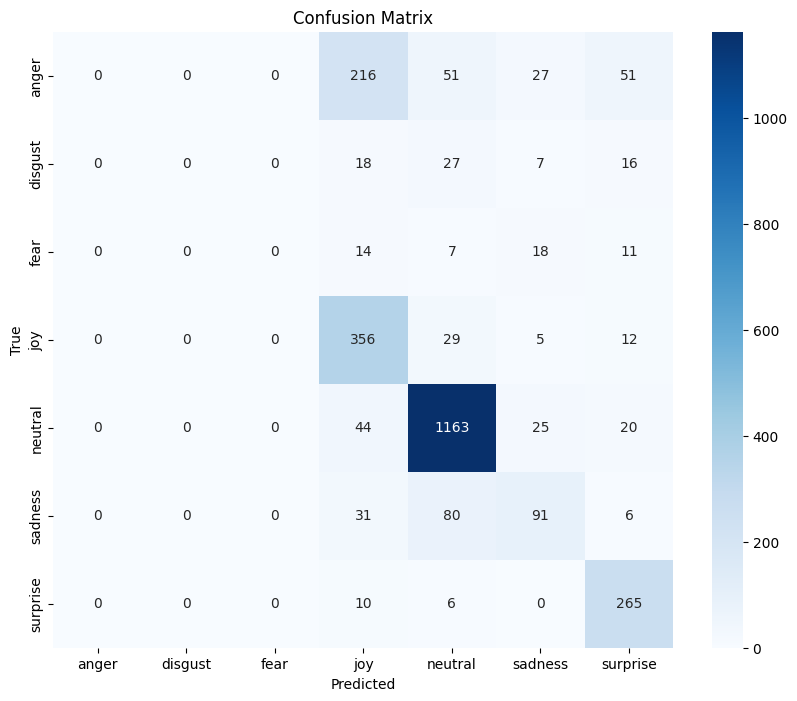

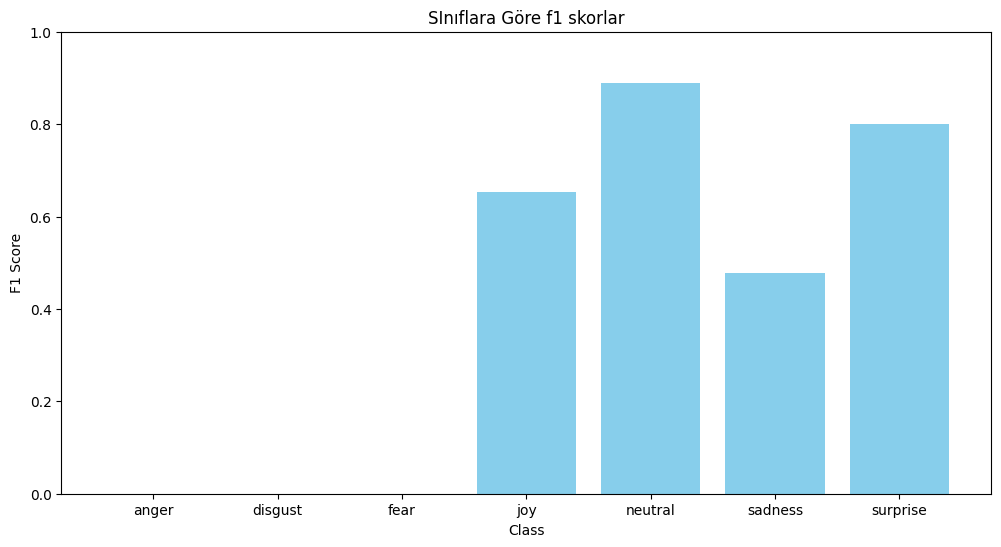

In [ ]:
# Sınıf isimlerini al
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Nihai karar modelinin tahminlerini al
final_predictions = decision_model.predict(combined_input)

# Tahminleri sınıflandırma etiketlerine dönüştür
y_pred = np.argmax(final_predictions, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# F1 skorunu hesapla
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Sınıflandırma raporunu yazdır
report = classification_report(y_true, y_pred, target_names=list(label_mapping.keys()), output_dict=True)
print("Classification Report:")
print(report)

# Confusion matrix'i hesapla
conf_matrix = confusion_matrix(y_true, y_pred)

# Confusion matrix'i görsel
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_names = list(label_mapping.keys())

# Sınıflara göre F1 skorları
f1_scores = [report[cls]['f1-score'] for cls in class_names]

# Her sınıf için doğru tahminlerin sayısı
correct_predictions = conf_matrix.diagonal()

# Sınıflara göre F1 skorları grafiği
plt.figure(figsize=(12, 6))
plt.bar(class_names, f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('SInıflara Göre f1 skorlar')
plt.ylim([0, 1])
plt.show()

In [ ]:
from keras.layers import concatenate

# Metin ve ses modellerinin çıktıları elde edilir.
text_predictions = text_model.predict(text_test_windows)
audio_predictions = audio_model.predict(audio_test_windows)

# Karar aşaması için bu çıktılar birleştirilir.
combined_input = np.concatenate([text_predictions, audio_predictions], axis=1)

# Nihai karar modeli
decision_input = Input(shape=(combined_input.shape[1],))
x = Dense(512, activation='relu')(decision_input)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(label_mapping), activation='softmax')(x)

decision_model = Model(inputs=decision_input, outputs=output_layer)
decision_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Karar modelinin eğitimi
early_stopping_decision = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_decision = decision_model.fit(combined_input, y_test_categorical,
                                      epochs=100, batch_size=64,
                                      validation_split=0.2,
                                      callbacks=[early_stopping_decision])

82/82 [==============================] - 0s 3ms/step
Epoch 1/100
33/33 [==============================] - 1s 9ms/step - loss: 0.9891 - accuracy: 0.6939 - val_loss: 3.6277 - val_accuracy: 0.1877
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.4986 - accuracy: 0.8488 - val_loss: 4.2702 - val_accuracy: 0.1801
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.8551 - val_loss: 4.5523 - val_accuracy: 0.1801
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 0.4677 - accuracy: 0.8556 - val_loss: 4.4647 - val_accuracy: 0.1839
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.4571 - accuracy: 0.8618 - val_loss: 4.7093 - val_accuracy: 0.1820
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.4490 - accuracy: 0.8565 - val_loss: 4.9489 - val_accuracy: 0.1820
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 0.4513 - accuracy: 0.8608 - 

In [ ]:
text_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 300)]          0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 5, 256)            439296    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 7)                 1799

In [ ]:
audio_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 1611)]         0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 5, 1024)           8699904   
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 512)               2623488   
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 3591

In [ ]:
decision_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_11 (Dense)            (None, 512)               7680      
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 140807 (550.03 KB)
Trainable params: 140807 (

In [ ]:
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# Nihai karar modelinin tahminlerini al
final_predictions = decision_model.predict(combined_input)

# Tahminleri sınıflandırma etiketlerine dönüştür
y_pred = np.argmax(final_predictions, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# F1 skorunu hesapla
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Sınıflandırma raporunu yazdır
report = classification_report(y_true, y_pred, target_names=list(label_mapping.keys()))
print("Classification Report:")
print(report)


82/82 [==============================] - 0s 1ms/step
F1 Score: 0.6525
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.52      0.89      0.65       402
     neutral       0.85      0.93      0.89      1252
     sadness       0.53      0.44      0.48       208
    surprise       0.70      0.94      0.80       281

    accuracy                           0.72      2606
   macro avg       0.37      0.46      0.40      2606
weighted avg       0.61      0.72      0.65      2606



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
